In [1]:
from Maximus_optimized_non_dominated import Multi_Fair as maximus
from sklearn.model_selection import StratifiedShuffleSplit as ss
from DataPreprocessing.my_utils import get_score,get_fairness,vis
import numpy as np

In [2]:
from DataPreprocessing.load_credit import load_credit
X, y, sa_index, p_Group, x_control,F = load_credit()
protected=[F[v] for v in sa_index]
dt='Credit'

[2.659488361359545, -1.1375335092714727]
Features we will be using for classification are: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target'] 



In [3]:
sss = ss(n_splits=2,test_size=0.4) #for reporting experiments use n_splits=10
preference=[[0,0,1],[0,1,1],[1,0,0],[1,1,0],[1,0,1],[0,1,0],[1.0,0.05,0.05]]

In [4]:
X = X[:5000,:]
y = y[:5000]

In [5]:
soln_per_dir={}
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf=maximus(n_estimators=499,saIndex=sa_index,
        saValue=p_Group,
        preference=preference)
    clf.fit(X_train,y_train)
    print(clf.preference_direction_to_solution_mapping)
    # caling clf.PF will give the pareto front
    for (a,b,c) in clf.preference_direction_to_solution_mapping:
        clf.estimators_=clf.estimators_[:c]
        clf.estimator_alphas_=clf.estimator_alphas_[:c]
        pred=clf.predict(X_test)
        #print(confusion_matrix(y_test,pred))
        if str(a) in soln_per_dir:
            soln_per_dir[str(a)].append([test_index,pred])
        else:
            soln_per_dir[str(a)]=[]
            soln_per_dir[str(a)].append([test_index,pred])


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

[(array([1.  , 0.05, 0.05]), array([0.32766667, 0.12295243, 0.01357324]), 444), (array([1., 0., 1.]), array([0.28133333, 0.02358578, 0.03573902]), 328), (array([0., 0., 1.]), array([0.21866667, 0.23365035, 0.02912338]), 175), (array([0., 1., 1.]), array([0.20333333, 0.47769847, 0.03422635]), 45), (array([0., 1., 0.]), array([0.22133333, 1.        , 0.        ]), 2)]
[(array([1., 0., 1.]), array([0.277     , 0.00787568, 0.07432624]), 233), (array([0., 0., 1.]), array([0.20766667, 0.26518402, 0.02998822]), 204), (array([0., 1., 1.]), array([0.18933333, 0.56337164, 0.0465931 ]), 47), (array([0., 1., 0.]), array([0.20366667, 0.83894826, 0.02023814]), 8)]


In [6]:
len(clf.all_PF_iterations)

500

In [7]:
clf.map_cosd

[[array([0., 0., 1.]), array([0.206     , 0.33888637, 0.08296131])],
 [array([0., 1., 1.]), array([0.189     , 0.61021827, 0.0693905 ])],
 [array([1., 0., 0.]), array([0.27733333, 0.01131581, 0.03792296])],
 [array([1., 1., 0.]), array([0.22133333, 1.        , 0.        ])],
 [array([1., 0., 1.]), array([0.28866667, 0.00256334, 0.0655506 ])],
 [array([0., 1., 0.]), array([0.22133333, 1.        , 0.        ])],
 [array([1.  , 0.05, 0.05]), array([0.27733333, 0.01131581, 0.03792296])]]

In [8]:
clf.preference_direction_to_solution_mapping

[(array([1., 0., 1.]), array([0.277     , 0.00787568, 0.07432624]), 233),
 (array([0., 0., 1.]), array([0.20766667, 0.26518402, 0.02998822]), 204),
 (array([0., 1., 1.]), array([0.18933333, 0.56337164, 0.0465931 ]), 47),
 (array([0., 1., 0.]), array([0.20366667, 0.83894826, 0.02023814]), 8)]

[[0.277      0.         0.         0.        ]
 [0.         0.         0.83894826 0.83894826]
 [0.07432624 0.07432624 0.07432624 0.        ]]
[[0.277      0.277      0.277     ]
 [0.         0.83894826 0.04194741]
 [0.         0.         0.00371631]]
[[0.277      0.00787568 0.07432624]
 [0.20766667 0.26518402 0.02998822]
 [0.18933333 0.56337164 0.0465931 ]
 [0.20366667 0.83894826 0.02023814]]


<Figure size 432x288 with 0 Axes>

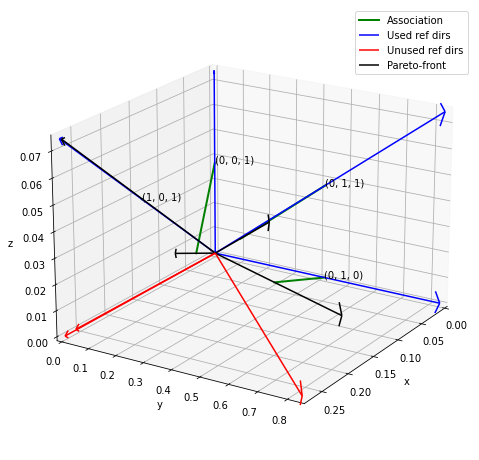

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pareto_front(associations, all_preference_vectors=None):
    plt.clf()
    
    pareto_front = np.row_stack([r[1] for r in associations])
    
    used_ref_dirs = np.row_stack([r[0] for r in associations])
    unused_ref_dirs = []
    for row in all_preference_vectors:
        isin = False
        for used_row in used_ref_dirs:
            if np.array_equal(row, used_row):
                isin = True
        if not isin:    
            unused_ref_dirs.append(row)
    unused_ref_dirs = np.row_stack(unused_ref_dirs).T
    used_ref_dirs = used_ref_dirs.T
    
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d')
    scale_factor_x = 1.0 / max(pareto_front[:,0])
    scale_factor_y = 1.0 / max(pareto_front[:,1])
    scale_factor_z = 1.0 / max(pareto_front[:,2])
    
    orig_used_ref_dirs = used_ref_dirs.copy().T
    
    used_ref_dirs[0,:] /= scale_factor_x
    used_ref_dirs[1,:] /= scale_factor_y
    used_ref_dirs[2,:] /= scale_factor_z

    unused_ref_dirs[0,:] /= scale_factor_x
    unused_ref_dirs[1,:] /= scale_factor_y
    unused_ref_dirs[2,:] /= scale_factor_z
    
    ax.set_xlim(0,1/scale_factor_x)
    ax.set_ylim(0,1/scale_factor_y)
    ax.set_zlim(0,1/scale_factor_z)
    ax.view_init(elev=20., azim=32)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ratio = 0.02
    
    print(used_ref_dirs)
    print(unused_ref_dirs)

    x, y, z = np.zeros((3,used_ref_dirs.shape[1]))
    u, v, w = used_ref_dirs
    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
              color="blue", label="Used ref dirs", zorder=0)
    
    x, y, z = np.zeros((3,unused_ref_dirs.shape[1]))
    u, v, w = unused_ref_dirs
    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
              color="red", label="Unused ref dirs", zorder=0)
    
    for i,row in enumerate(orig_used_ref_dirs):
        x,y,z = row
        label = '(%d, %d, %d)' % (x, y, z)
        xx, yy, zz = used_ref_dirs.T[i,:] / 2
        ax.text(xx, yy, zz, label)
    
    print(pareto_front)
    pareto_front = pareto_front.T
    #ax.scatter(xs=pareto_front[:,0],ys=pareto_front[:,1],zs=pareto_front[:,2],label="Pareto-front",
    #           color="k", s=35)
    x, y, z = np.zeros((3,pareto_front.shape[1]))
    u, v, w = pareto_front
    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
              color="black", label="Pareto-front", zorder=1)
    
    for i, row in enumerate(pareto_front.T):
        associated_vector = used_ref_dirs.T[i,:]
        x,y,z = row / 2
        xx,yy,zz = associated_vector / 2
        ax.plot([x,xx],[y,yy],[z,zz],color="green",linewidth=2, label="Association" if i==0 else None)
        
        
    
    plt.legend()
    plt.savefig("pareto_front_with_ref_dirs.pdf")
    plt.show()
    
plot_pareto_front(clf.preference_direction_to_solution_mapping, np.array(clf.preference))

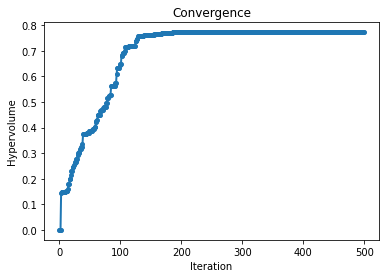

In [94]:
from pymoo.performance_indicator.hv import Hypervolume

def plot_hypervolume(pareto_fronts):
    # MODIFY - this is problem dependend
    ref_point = np.array([1.0, 1.0, 1.0])

    # create the performance indicator object with reference point
    metric = Hypervolume(ref_point=ref_point, normalize=False)

    # calculate for each generation the HV metric
    hv = [metric.calc(f) for f in pareto_fronts]
    
    n_evals = np.arange(len(hv))
    # visualze the convergence curve
    plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2)
    plt.title("Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Hypervolume")
    plt.savefig("hypervolume_convergence.pdf", dpi=300)
    plt.show()
    
plot_hypervolume(clf.all_PF_iterations)

In [6]:
reference_performance_map={}
for a in soln_per_dir: # each 'a' is a survived reference direction
    map_index_to_pred=np.array(soln_per_dir[a])
    in_ts=map_index_to_pred[:,0] #test_instance_indexes
    pred=map_index_to_pred[:,1] #test_predictions
    rs=get_fairness(sa_index,p_Group,in_ts,pred,X,y)
    p=get_score(pred,in_ts,X,y)
    reference_performance_map[a]=[list(rs.values()),p]



For Sensitive attribute index  1
avg_TPR_unprot: 0.7378277153558053 avg_TPR_prot: 0.6818181818181818
avg_TNR_unprot: 0.6026637069922308 avg_TNR_prot: 0.6234756097560976

-------------------------------------------



For Sensitive attribute index  3
avg_TPR_unprot: 0.7330316742081447 avg_TPR_prot: 0.6981981981981982
avg_TNR_unprot: 0.6296715741789355 avg_TNR_prot: 0.5875370919881305

-------------------------------------------



For Sensitive attribute index  4
avg_TPR_unprot: 0.7100271002710027 avg_TPR_prot: 0.7432432432432432
avg_TNR_unprot: 0.6107828655834564 avg_TNR_prot: 0.6157635467980296

-------------------------------------------

avg_TPR: 0.7155756207674944 avg_TNR: 0.6114322414900449
avg_acc: 0.6345 avg_Bacc: 0.6635039311287696
avg_auc: 0.6635039311287697 avg_GM: 0.661457485981903


For Sensitive attribute index  1
avg_TPR_unprot: 0.674631394301427 avg_TPR_prot: 0.6053618711385702
avg_TNR_unprot: 0.6803125711154592 avg_TNR_prot: 0.7269469405220368

-----------------------

In [7]:
results=np.array(list(reference_performance_map.values()))[:,0]
performance=np.array(list(reference_performance_map.values()))[:,1]

['CDM', 'DM', 'CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.0768214363014903, 0.0768214363014903, 0.007301006180858383, 0.07696795820075153, 0.028235461757667335, 0.038196824186813694, 0.0560095335376235, 0.7155756207674944, 0.6114322414900449, 0.6345, 0.6635039311287697, 0.661457485981903], [0.11590389256943445, 0.11590389256943445, 0.03559109374657432, 0.03559109374657432, 0.048815204609794494, 0.048815204609794494, 0.06926952316285684, 0.644469525959368, 0.7007064868336544, 0.68825, 0.6725880063965113, 0.6719464029725308], [0.09224727575059055, 0.09224727575059055, 0.04464134069583836, 0.04464134069583836, 0.0067793877412083425, 0.0344479990251243, 0.06095244538445277, 0.5395033860045146, 0.8124598587026333, 0.752, 0.675981622353574, 0.6615215432196084], [0.007184758297479443, 0.007184758297479443, 0.07851824730662826, 0.07851824730662826, 0.0449154937803401, 0.044915493780340154, 0.058828662463512704, 0.3724604966139955, 0.9039820166987798, 0.78625, 0.6

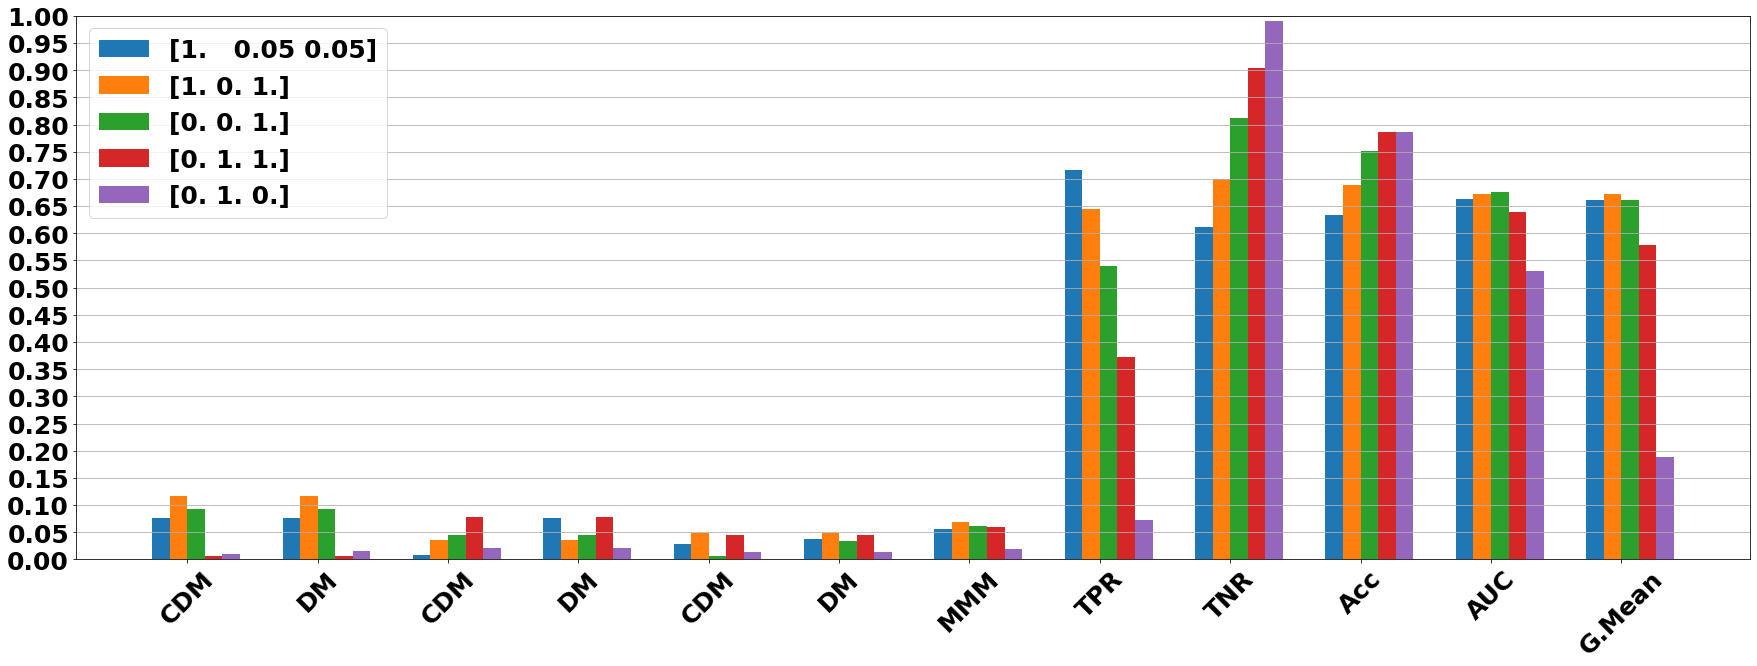

In [8]:
dt='Credit'
vis('',results,performance,L=protected,dt=dt,clfs=list(reference_performance_map.keys()))

In [9]:
protected    #SEX               #MARRIAGE            #AGE

['SEX', 'MARRIAGE', 'AGE']

# Check the anaomaly here [1,1,0] which meaningfully refers to the direction with best fairness has slightly worse fairness than [0,1,0] which refers to direction with best accuracy, fairness trade-off

# 